In [3]:
import scanpy as sc
import numpy as np
import scanpy as sc
import glob
import os
import json
from PIL import Image, ImageDraw
import shapely

#### Some peyers patches were not filtered out because we didn't catch them in the earlier filtering steps. We remove them here to make a peyers-free object.

Put in the path to the final object from the previous script

In [4]:
adata = sc.read(r'/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned/full_xenium_replicates_and_reference.h5ad')

/home/amonell/mambaforge/envs/merscope_01/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


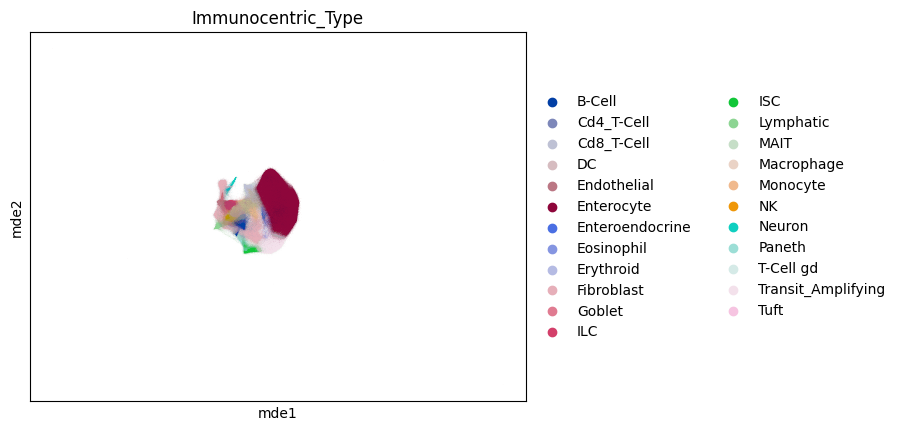

In [8]:
#plot the immunocentric cells so that they can be assigned colors
sc.pl.embedding(adata, basis='mde', color = 'Immunocentric_Type')

#### The following will export an image of the spatial roll colored by immunocentric type, which can be used to identify peyers patches.

In [10]:
for input_file in np.unique(adata.obs.batch):
    current_adata = adata[adata.obs['batch'] == input_file]
    all_spatial = current_adata.obsm['X_spatial']

    Immunocentric_Type_categories = current_adata.obs['Immunocentric_Type'].cat.categories
    Immunocentric_Type_colors = current_adata.uns['Immunocentric_Type_colors']
    
    Immunocentric_Type_dict = {category: Immunocentric_Type_colors[i] for i, category in enumerate(Immunocentric_Type_categories)}
    image_colors = [Immunocentric_Type_dict.get(v) for v in current_adata.obs.Immunocentric_Type]

    #D6, D7, D30 #downsize = 20
    downsize = 5
    # Example 2D point array (replace this with your own data)
    points = all_spatial/downsize
    
    # Define the size of the image (adjust as needed)
    image_width = 2000
    image_height = 2000
    
    # Create a white canvas as the base image
    base_image = Image.new('RGB', (image_width, image_height), (255, 255, 255))
    
    # Draw the points on the image
    draw = ImageDraw.Draw(base_image)
    point_size = 1  # Size of the points
    ct = 0
    for point in points:
        draw.ellipse((point[0] - point_size, point[1] - point_size, point[0] + point_size, point[1] + point_size),
                     fill=image_colors[ct])
        ct += 1

    try:
        os.mkdir(os.path.join('/mnt/sata1/Analysis_Alex/timecourse_replicates/peyers', input_file))
    except:
        print('filtering directory already exists')
    file_path = os.path.join('/mnt/sata1/Analysis_Alex/timecourse_replicates/peyers', input_file, 'Immunocentric_Type_image.png')
    base_image.save(file_path)

#### After labeling Peyers patches in labelme, we remove them here

In [15]:
from tqdm.notebook import tqdm
remove_ids = []
for input_file in tqdm(np.unique(adata.obs.batch)):
    current_adata = adata[adata.obs['batch'] == input_file]
    json_file_path =os.path.join('/mnt/sata1/Analysis_Alex/timecourse_replicates/peyers', input_file, 'Immunocentric_Type_image.json')
    all_spatial = current_adata.obsm['X_spatial']
    
    # Load the JSON data from the file
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)
    
    # Extract relevant information from the JSON data
    image_height = data['imageHeight']
    image_width = data['imageWidth']
    image_path = data['imagePath']
    shapes = data['shapes']
    
    # Process the shapes (annotations)
    removals = []
    points = [] 
    top_points = [] 
    for shape in shapes:
        label = shape['label']
        removals.append(shape['points'])
    
    total_indices = []
    for ir in removals:
        ir_ = np.array(ir)*downsize
        poly = shapely.Polygon(ir_)
        indices = []
        for i in range(len(all_spatial)):
            pt = shapely.Point(all_spatial[i])
            if pt.within(poly):
                indices.append(i)
        total_indices.append(indices)
    
    total_indices=list(set([element for sublist in total_indices for element in sublist]))
    index_set = list(set(total_indices))
    if len(index_set) > 0:
        current_adata = current_adata[index_set, :]
        remove_ids.extend(current_adata.obs.index.values)
    print(len(remove_ids))

  0%|          | 0/11 [00:00<?, ?it/s]

957
2084
2084
3784
4411
5221
6005
7074
7270
8038
10388


#### And write the new object out...

In [17]:
adata = adata[~adata.obs.index.isin(remove_ids)]

In [20]:
adata.write('/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned/full_xenium_replicates_and_reference_no_peyers.h5ad')

/home/amonell/mambaforge/envs/merscope_01/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


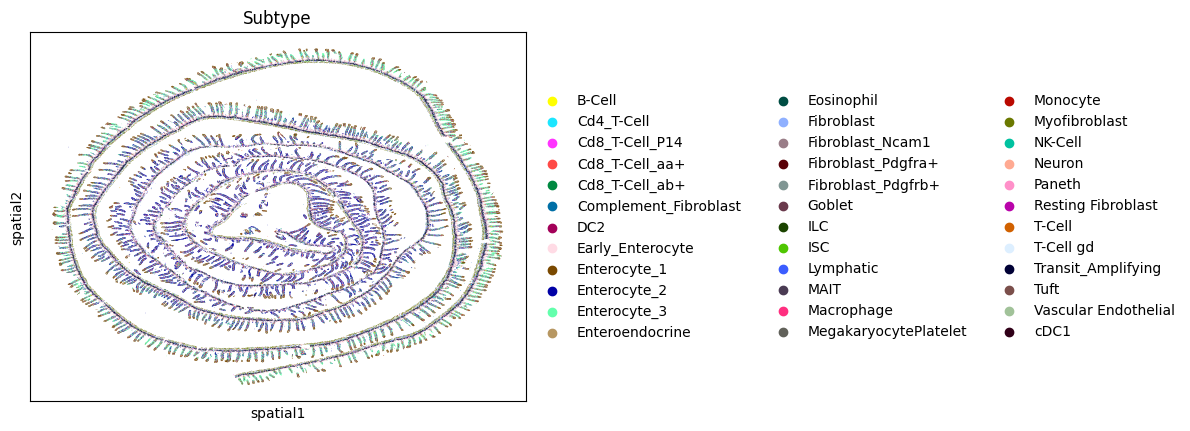

In [19]:
sc.pl.embedding(adata[adata.obs.batch.isin(['day90_SI_r2'])], basis='spatial', color='Subtype')